In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from fastai.imports import *
from fastai.core import *
from fastai.io import *
from fastai.dataloader import *
from fastai.conv_learner import *
from fastai.learner import *
import os
from audio_dataset import *
from audio_transforms import *

import IPython.display as ipd

In [2]:
import librosa
from librosa import display

In [3]:
#import audioread
#import soundfile as sf

## Load Data

In [3]:
PATH = Path('data/freesound')
TRN_PATH = PATH/'audio_train'
TEST_PATH = PATH/'audio_test'

In [4]:
AS_PATH = Path('data/audioset')

In [5]:
list(PATH.iterdir())

[PosixPath('data/freesound/sample_submission.csv'),
 PosixPath('data/freesound/models'),
 PosixPath('data/freesound/train.csv'),
 PosixPath('data/freesound/audio_train'),
 PosixPath('data/freesound/audio_test'),
 PosixPath('data/freesound/tmp')]

In [6]:
trn = pd.read_csv(PATH/'train.csv')
test = pd.read_csv(PATH/'sample_submission.csv')

In [7]:
trn.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [8]:
verified = list(trn['manually_verified'])

In [9]:
trn = trn[['fname','label']].copy()
trn_sample = trn[:1900]
trn.head()

,fname,label
0,00044347.wav,Hi-hat
1,001ca53d.wav,Saxophone
2,002d256b.wav,Trumpet
3,0033e230.wav,Glockenspiel
4,00353774.wav,Cello


In [ ]:
trn.to_csv('trn.csv', index=False)
trn_sample.to_csv('trn_sample.csv', index=False)

In [ ]:
test.head()

In [ ]:
trn.shape[0], len(trn.label.unique())

In [ ]:
fnames = list(trn['fname']) 
len(fnames), fnames[:5]

In [ ]:
test_fnames = list(test['fname']) 
len(test_fnames), test_fnames[:5]

In [ ]:
trn_wavs = (PATH/'audio_train').glob('*.wav')
test_wavs = (PATH/'audio_test').glob('*.wav')

In [5]:
# audioset
trn_wavs = (AS_PATH/'train_segments').glob('*.wav')
val_wavs = (AS_PATH/'eval_segments').glob('*.wav')

In [ ]:
n_mels=128
n_fft=1024
hop_length=512
sr=44100

fmin=125.0
fmax=7500.0

In [ ]:
>>> a = np.array([[1, 2], [3,4]])
>>> b = np.array([[2, 3], [5,6]])
>>> c = np.stack((a, b),axis=0)
a.shape, c.shape, c

In [23]:
aud, sr = librosa.load('data/freesound/audio_test/b39975f5.wav')
aud = np.append(aud,0.0001)
aud, sr

(array([ 0.0001]), 22050)

In [28]:
x, sr = open_audio('data/freesound/audio_test/b39975f5.wav')
x = get_mel(x, sr, feature_name='log_mel_spec')
x

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [11]:
a = get_audio(next(trn_wavs), melspect=True, feature_name='log_mel_spec'); a.shape

OSError: Error handling audio at: data/freesound/audio_test/b39975f5.wav

In [9]:
ipd.Audio(a, rate=44100)

In [10]:
D = librosa.amplitude_to_db(a, ref=np.max); 
print(D.shape, D[:5])
D = (D + 80.0) / 80.0
D.shape, D[:5]

(441000,) [-10.504    -9.57163 -10.34032 -13.11903 -14.95253]


((441000,),
 array([ 0.8687 ,  0.88035,  0.87075,  0.83601,  0.81309], dtype=float32))

In [29]:
aud = librosa.feature.melspectrogram(a, n_mels=n_mels)
aud = librosa.amplitude_to_db(aud, ref=1.0, amin=1e-2)
print(aud.shape, aud[:5])
aud = (aud) / 80.0
aud.shape, aud[:5]

(128, 862) [[ 31.09911  19.21134  -6.68211 ...,  -6.68211  11.96526  33.0639 ]
 [ 33.86597  21.72491  -6.68211 ...,  -6.68211  17.77336  39.18527]
 [ 44.69872  33.95916   9.02832 ...,  35.58044  30.82782  44.90226]
 [ 66.22835  62.1863   59.07463 ...,  49.25155  42.83544  41.88529]
 [ 69.19032  72.60608  70.74844 ...,  36.67476  55.39982  62.77149]]


((128, 862),
 array([[ 0.38874,  0.24014, -0.08353, ..., -0.08353,  0.14957,  0.4133 ],
        [ 0.42332,  0.27156, -0.08353, ..., -0.08353,  0.22217,  0.48982],
        [ 0.55873,  0.42449,  0.11285, ...,  0.44476,  0.38535,  0.56128],
        [ 0.82785,  0.77733,  0.73843, ...,  0.61564,  0.53544,  0.52357],
        [ 0.86488,  0.90758,  0.88436, ...,  0.45843,  0.6925 ,  0.78464]]))

Text(0.5,1,'Full spectrogram')

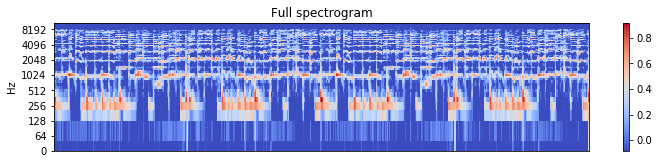

In [30]:
# Pre-compute a global reference power from the input spectrum
rp = np.max(np.abs(D))

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(aud, y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

In [ ]:
def rand1(s): return int(random.random()*s)

def focus_mel(aud, b, c):
    ''' highlights audio's mel_bands'''
    if b == 0: return aud
    mu = np.average(aud[:b])
    print(mu)
    print(aud[:b].shape)
    return aud[:b]+mu*c

In [ ]:
np.average(aud[:15])*.4

In [ ]:
mel_bands = focus_mel(aud, rand1(128), rand0(0.5))
mel_bands.shape

In [ ]:
import soundfile as sf
from librosa.feature import chroma_stft
from librosa.feature import melspectrogram

wav = next(trn_wavs)
block_gen = sf.blocks(wav, blocksize=1024)
rate = sf.info(wav).samplerate

In [ ]:
def segment_size(f):
    l = len(librosa.load(wav)[0])
    return l // 1024

In [ ]:
segment_size(wav)

In [ ]:
chromas = []
for bl in block_gen:
    # downmix frame to mono (averaging out the channel dimension)
    #y=np.mean(bl, axis=1)
    # compute chroma feature
    chromas.append(melspectrogram(bl, n_fft=1024, hop_length=256, n_mels=128, sr=rate))

In [ ]:
chromas[0].shape

In [ ]:
mag, _ = librosa.core.magphase(D, power=2) 
mag[0,:5]

In [ ]:
logmag = librosa.power_to_db(mag, ref=1.0)
logmag[0,:5]

In [ ]:
import matplotlib.pyplot as plt
>>> librosa.display.specshow(aud,
...                          y_axis='log', x_axis='time')
>>> plt.title('Power spectrogram')
plt.xlim(xmax=5)
>>> plt.colorbar(format='%+2.0f dB')
>>> plt.tight_layout()

In [ ]:
#>>> D = np.abs(librosa.stft(y))**2
aud = (np.abs(aud))**2
aud = librosa.feature.melspectrogram(S=aud)

In [ ]:
aud

In [ ]:
>>> librosa.display.specshow(aud,
...                          y_axis='log', x_axis='time')
>>> plt.title('Power spectrogram')
>>> plt.colorbar(format='%+2.0f dB')
>>> plt.tight_layout()

In [ ]:
aud.shape

In [ ]:
aud = librosa.feature.melspectrogram(S=aud, sr=44100, n_fft=1024, hop_length=512); aud.shape

In [ ]:
aud_fast = librosa.phase_vocoder(aud, 2.0); aud_fast.shape

In [ ]:
n_fft=[512,1024,2048]
feature
for i in range(len(n_fft)):
    print(i)

In [ ]:
%debug

In [ ]:
np.rollaxis(a,2).shape

In [ ]:
file = next(trn_wavs); file

In [ ]:
data, samplerate = sf.read('data/audioset/train_segments/sf_Y4QGc5-4_30.000.wav', dtype='float32')

In [8]:
get_audio('sf_Y4QGc5-4_30.000.wav', melspect=True, feature_name='log_mel_spec').shape

(128, 1723)

In [ ]:
data[:5,:]

In [ ]:
x,_ = librosa.load(file, sr=None); x.shape

In [ ]:
aud_arr = np.array([get_audio(o, melspect=True, feature_name='log_mel_spec') for o in list(trn_wavs)])

In [7]:
# audioset
trn_wavs = (AS_PATH/'train_segments').glob('*.wav')
val_wavs = (AS_PATH/'eval_segments').glob('*.wav')
trn_joined = (AS_PATH/'train_joined').glob('*.wav')

means = []
for o in list(trn_joined):
    try:
        aud = get_audio(o, melspect=True, feature_name='log_mel_spec')
    except: 
        print(o)
    else:
        means.append(np.mean(aud))
        
means = np.array(means)
std = np.std(means)
mean = np.mean(means)
mean, std

(0.350691453480658, 0.2553918077903391)

In [20]:
np.std(means)

0.23081250589524555

In [16]:
np.mean(sums)

83776.766002963908

In [ ]:
os.mkdir(AS_PATH/'tmp', exist_ok=True)
np.save(AS_PATH/'tmp/aud_arr_audioset.npy', aud_arr)

In [ ]:
aud_arr = np.load(PATH/'tmp/aud_arr_ch1.npy'); aud_arr.shape

In [ ]:
mean = np.mean(aud_arr)
std = np.std(aud_arr)
stats = (np.array([mean]), np.array([std]))
mean, std

In [ ]:
stats = (np.array([ 0.18637 ,  0.35956,  0.57300]), np.array([ 0.30634,  0.40104,  0.48204]))

In [ ]:
m = np.array(stats[0]); m.shape

In [ ]:
a-m

In [ ]:
stats = (np.array([mean]), np.array([std]))
# audioset
#stats = (np.array([0.29112]), np.array([0.23325]))

### Distribution of Categories

In [ ]:
cat_grp = trn.groupby(['label', 'manually_verified']).count()
plot = cat_grp.unstack().reindex(cat_grp.unstack().sum(axis=1).sort_values().index).plot(
    kind='bar', stacked=True, title='Number of Audio Samples per Category', figsize=(16,10))
plot.set_xlabel('Category')
plot.set_ylabel('Number of Samples');

Fairly small percentage of "manually verified" sound clips.

In [ ]:
print('Minimum samples in a category:', min(trn.label.value_counts()))
print('Maximum samples in a category:', max(trn.label.value_counts()))

In [ ]:
import wave

f = str(PATH/'audio_train/001ca53d.wav')
wav = wave.open(f)
print('Sampling (frame) rate:', wav.getframerate())
print('Total samples (frames):', wav.getnframes())
print('Duration:', wav.getnframes()/wav.getframerate())

In [ ]:
#import torchaudio -- torchaudio not available in Fastai environment
# using scipy
from scipy.io import wavfile
rate, data = wavfile.read(f)
print('Sampling (frame) rate:', rate)
print('Total samples (frames):', data.shape)
print(data)

Plot audio frames

In [ ]:
plt.plot(data, '-', );

Zoom in to view 250 frames

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(data[25250:25500], '.'); plt.plot(data[25250:25500], '-');

In [ ]:
trn['nframes'] = trn['fname'].apply(lambda f: wave.open('data/freesound/audio_train/'+f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('data/freesound/audio_test/'+f).getnframes())

_,ax = plt.subplots(figsize=(16,4))
sns.violinplot(ax=ax, x='label', y='nframes', data=trn)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
trn.nframes.hist(bins=100, ax=axes[0])
test.nframes.hist(bins=100, ax=axes[1])
plt.suptitle("Frame Length Distribution in Train and Test", ha='center', fontsize='large');

1. The majority of frame lengths are short.
2. There are 4 abnormal lengths in test set. Let's analyze them.

### Listen to Sounds

In [ ]:
[preds[i] for i in idx[:10]]

In [ ]:
#play sample with stats
n = 11
#length = 3*44100
sample = os.path.join(TRN_PATH, fnames[n])
print(test_fnames[n])
raw = open_audio(sample)
raw_len = len(raw)
raw_s = adj_length(raw)
print('raw length: ', raw_len, 'sample length:', len(raw_s))
print('label:', trn['label'].iloc[n], 'verified:', verified[n])
ipd.Audio(raw_s, rate=44100)

### Audio_transforms

In [ ]:
class Transform():
    """ A class that represents a transform.

    All other transforms should subclass it. All subclasses should override
    do_transform.

    Arguments
    ---------
        tfm_y : TfmType
            type of transform
    """
    def __init__(self, tfm_y=TfmType.NO):
        self.tfm_y=tfm_y
        self.store = threading.local()

    def set_state(self): pass
    def __call__(self, x, y):
        self.set_state()
        x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
                else self.transform(x,y) if self.tfm_y in (TfmType.PIXEL, TfmType.CLASS)
                else self.transform_coord(x,y))
        return x, y

    def transform_coord(self, x, y): return self.transform(x),y

    def transform(self, x, y=None):
        x = self.do_transform(x,False)
        return (x, self.do_transform(y,True)) if y is not None else x

    @abstractmethod
    def do_transform(self, x, is_y): raise NotImplementedError


class Denormalize():
    """ De-normalizes an image, returning it to original format.
    """
    def __init__(self, m, s):
        self.m=np.array(m, dtype=np.float32)
        self.s=np.array(s, dtype=np.float32)
    def __call__(self, x): return x*self.s+self.m


class Normalize():
    """ Normalizes an image to zero mean and unit standard deviation, given the mean m and std s of the original image """
    def __init__(self, m, s): #tfm_y=TfmType.NO
        self.m=np.array(m, dtype=np.float32)
        self.s=np.array(s, dtype=np.float32)
        #self.tfm_y=tfm_y

    def __call__(self, x, y=None):
        x = (x-self.m)/self.s
        #if self.tfm_y==TfmType.PIXEL and y is not None: y = (y-self.m)/self.s
        return x,y

def get_mfcc(s,y):
    x = librosa.feature.mfcc(S=librosa.power_to_db(s[0,:,:]))
    x = x.reshape(1,x.shape[0],x.shape[1])
    return x, y

def log_mel(s,y):
    x = librosa.amplitude_to_db(s[0,:,:])
    x = x + .001
    x = x.reshape(1,x.shape[0],x.shape[1])
    return x, y
       
def compose(im, y, fns):
    """ apply a collection of transformation functions fns to images
    """
    for fn in fns:
        #pdb.set_trace()
        im, y =fn(im, y)
    return im if y is None else (im, y)


class Transforms():
    def __init__(self, sz, tfms, normalizer, denorm, crop_type=CropType.CENTER,
                 tfm_y=TfmType.NO, sz_y=None):
        if sz_y is None: sz_y = sz
        self.sz,self.denorm,self.norm,self.sz_y = sz,denorm,normalizer,sz_y
        crop_tfm = crop_fn_lu[crop_type](sz, tfm_y, sz_y)
        self.tfms = tfms
        self.tfms.append(crop_tfm)
        if normalizer is not None: self.tfms.append(normalizer)
        self.tfms.append(ChannelOrder(tfm_y))

    def __call__(self, im, y=None): return compose(im, y, self.tfms)
    def __repr__(self): return str(self.tfms)


def image_gen(normalizer, denorm, sz, tfms=None, max_zoom=None, pad=0, crop_type=None,
              tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, scale=None):
    """
    Generate a standard set of transformations

    Arguments
    ---------
     normalizer :
         image normalizing function
     denorm :
         image denormalizing function
     sz :
         size, sz_y = sz if not specified.
     tfms :
         iterable collection of transformation functions
     max_zoom : float,
         maximum zoom
     pad : int,
         padding on top, left, right and bottom
     crop_type :
         crop type
     tfm_y :
         y axis specific transformations
     sz_y :
         y size, height
     pad_mode :
         cv2 padding style: repeat, reflect, etc.

    Returns
    -------
     type : ``Transforms``
         transformer for specified image operations.

    See Also
    --------
     Transforms: the transformer object returned by this function
    """
    if tfm_y is None: tfm_y=TfmType.NO
    if tfms is None: tfms=[]
    elif not isinstance(tfms, collections.Iterable): tfms=[tfms]
    if sz_y is None: sz_y = sz
    if scale is None:
        scale = [RandomScale(sz, max_zoom, tfm_y=tfm_y, sz_y=sz_y) if max_zoom is not None
                 else Scale(sz, tfm_y, sz_y=sz_y)]
    elif not is_listy(scale): scale = [scale]
    if pad: scale.append(AddPadding(pad, mode=pad_mode))
    if crop_type!=CropType.GOOGLENET: tfms=scale+tfms
    return Transforms(sz, tfms, normalizer, denorm, crop_type,
                      tfm_y=tfm_y, sz_y=sz_y)

def noop(x):
    """dummy function for do-nothing.
    equivalent to: lambda x: x"""
    return x

class AudTransforms():
    def __init__(self, tfms, normalizer, denorm):
        #if sz_y is None: sz_y = sz
        #self.sz,self.denorm,self.norm,self.sz_y = sz,denorm,normalizer,sz_y
        self.denorm,self.norm = denorm,normalizer
        #crop_tfm = crop_fn_lu[crop_type](sz, tfm_y, sz_y)
        self.tfms = tfms
        #self.tfms.append(crop_tfm)
        if normalizer is not None: self.tfms.append(normalizer)
        #self.tfms.append(ChannelOrder(tfm_y))

    def __call__(self, im, y=None): return compose(im, y, self.tfms) 
    def __repr__(self): return str(self.tfms)

def audio_gen(normalizer, denorm, tfms=None):
    if tfms is None: tfms = []
    elif not isinstance(tfms, collections.Iterable): tfms=[tfms]
    return AudTransforms(tfms, normalizer, denorm)

def aud_tfms_from_stats(stats, aug_tfms=None):
#def tfms_from_stats(stats, sz, aug_tfms=None, max_zoom=None, pad=0, crop_type=CropType.RANDOM,
                    #tfm_y=None, sz_y=None, pad_mode=cv2.BORDER_REFLECT, norm_y=True, scale=None):
    """ Given the statistics of the training image sets, returns separate training and validation transform functions
    """
    #if aug_tfms is None: aug_tfms=[]
    #tfm_norm = Normalize(*stats, tfm_y=tfm_y if norm_y else TfmType.NO) if stats is not None else None
    tfm_norm = Normalize(*stats)
    tfm_denorm = Denormalize(*stats) if stats is not None else None
    #val_crop = CropType.CENTER if crop_type in (CropType.RANDOM,CropType.GOOGLENET) else crop_type
    #val_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=val_crop,
            #tfm_y=tfm_y, sz_y=sz_y, scale=scale)
    val_tfm = audio_gen(tfm_norm, tfm_denorm, tfms=aug_tfms)
    #trn_tfm = image_gen(tfm_norm, tfm_denorm, sz, pad=pad, crop_type=crop_type,
            #tfm_y=tfm_y, sz_y=sz_y, tfms=aug_tfms, max_zoom=max_zoom, pad_mode=pad_mode, scale=scale)
    trn_tfm = audio_gen(tfm_norm, tfm_denorm, tfms=aug_tfms)
    return trn_tfm, val_tfm


### ResNet

In [ ]:
def conv(ni, nf, ks=3, stride=1):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)


def bn1(planes):
    m = nn.BatchNorm1d(planes)
    m.weight.data.fill_(1)
    m.bias.data.zero_()
    return m

def bn(planes, init_zero=False):
    m = nn.BatchNorm2d(planes)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

class fc1(nn.Module):
    def __init__(self, ni, nf, ks=2, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(ni,nf,kernel_size=ks,stride=stride, padding=padding)
        self.relu = nn.ReLU(inplace=True)
        self.max = nn.MaxPool2d(2, stride=2, padding=1)
    
    def forward(self,x):
        out = self.conv(x)
        #return self.relu(out)
        out = self.relu(out)
        out = self.max(out)
        return out

class fc2(nn.Module):
    def __init__(self, ni, nf, ks=1, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(ni,nf,kernel_size=ks,stride=stride)
        #self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,x):
        out = self.conv(x)
        #return self.sigmoid(out)
        return self.relu(out)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.conv1 = conv(inplanes, planes, stride=stride)
        self.bn1 = bn(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv(planes, planes)
        self.bn2 = bn(planes)
        self.downsample = downsample
        self.stride = stride
        #self.max = nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        #self.drop = nn.Dropout2d(0.1)

    def forward(self, x):
        residual = x
        if self.downsample is not None: residual = self.downsample(x)

        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn1(out)

        out = self.conv2(out)

        out = residual + out
        out = self.relu(out)
        out = self.bn2(out)
        
        #out = self.max(out)
        #out = self.drop(out)

        return out
    

class MyResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, k=1, vgg_head=False):
        super().__init__()
        self.inplanes = 64

        features = [conv(1, 64, ks=3, stride=2)
            , bn(64) , nn.ReLU(inplace=True) , nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
            , self._make_layer(block, int(64*k), layers[0])
            , self._make_layer(block, int(128*k), layers[1], stride=2)
            , self._make_layer(block, int(256*k), layers[2], stride=2)
            , self._make_layer(block, int(512*k), layers[3], stride=2)]
        out_sz = int(512*k) * block.expansion

        if vgg_head:
            features += [nn.AdaptiveAvgPool2d(3), Flatten()
                , nn.Linear(out_sz*3*3, 4096), nn.ReLU(inplace=True), bn1(4096), nn.Dropout(0.25)
                , nn.Linear(4096,   4096), nn.ReLU(inplace=True), bn1(4096), nn.Dropout(0.25)
                , nn.Linear(4096, num_classes)]
        else: features += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(out_sz, num_classes)]
        #else: features += [nn.AdaptiveMaxPool2d(3), fc1(out_sz, 1024), fc2(1024, 41), nn.AdaptiveAvgPool2d(1),
                           #Flatten(), nn.Linear(41, num_classes)]

        self.features = nn.Sequential(*features)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv(self.inplanes, planes*block.expansion, ks=1, stride=stride),
                bn(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks): layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)#, nn.Dropout2d(0.5))

    def forward(self, x): return self.features(x)


In [ ]:
# from John
def mapk_np(preds, targs, k=3):
    preds = np.argsort(-preds, axis=1)[:, :k]
    score = 0.0
    for i in range(k):
        num_hits = (preds[:, i] == targs).sum()
        score += num_hits * (1.0 / (i+1.0))
    score /= preds.shape[0]
    return score

def mapk(preds, targs, k=3):
    return mapk_np(to_np(preds), to_np(targs), k)

### Model

In [ ]:
tfms = aud_tfms_from_stats(stats, aug_tfms=None)
md = AudioClassifierData.from_csv(PATH, 'audio_train', 'trn_sample.csv', tfms=tfms, test_name='audio_test')

In [ ]:
m = MyResNet(BasicBlock, [3, 4, 6, 3], num_classes=41, vgg_head=False)
#model = BasicModel(to_gpu(m), name='ResNet')
opt = optim.Adam
metrics = [accuracy, mapk]
loss = F.cross_entropy
learn = ConvLearner.from_model_data(m, md, crit=loss, metrics=metrics, opt_fn=opt)

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.fit(1e-3, 1, wds=1e-5, cycle_len=5, use_clr_beta=(5,20,0.95,0.75))

In [ ]:
learn.save('2d_resnet_trim_adj')

In [ ]:
learn.load('2d_resnet_aug')

In [ ]:
learn.fit(1e-3, 1, wds=1e-5, cycle_len=5, use_clr_beta=(5,20,0.95,0.75))

In [ ]:
learn.save('2d_resnet_trim_adj_2')

In [ ]:
learn.load('resnet_2_connected')

In [ ]:
learn.fit(1e-3, 1, wds=1e-5, cycle_len=5, use_clr_beta=(5,20,0.95,0.75))

In [ ]:
learn.save('2d_resnet_trim_adj_3')

In [ ]:
learn.load('2d_resnet_trim_adj_3')

In [ ]:
learn.freeze()

In [ ]:
learn.fit(1e-3, 3, wds=1e-5)

In [ ]:
learn.model.eval()
val_preds = learn.predict_with_targs()

val_acc = accuracy_np(*val_preds)
val_map = mapk_np(*val_preds)

print(f'Val Acc: {val_acc:.3f}, Val MAP: {val_map:.3f}')

### Predictions

In [ ]:
multi_preds, y = learn.TTA(is_test=True)

In [ ]:
%debug

In [ ]:
preds = np.mean(multi_preds, 0)

In [ ]:
np.save(PATH/'tmp/preds_6.npy', preds)

In [ ]:
preds = np.load(PATH/'tmp/preds_6.npy')

In [ ]:
top_3_idx = [np.argsort(preds[i])[-3:][::-1] for i in range(len(test_fnames))]
classes = np.array(sorted(trn.label.unique()))
pred_labels = [list(classes[[top_3_idx[i]]]) for i in range(len(test_fnames))]
preds = [" ".join(ls) for ls in pred_labels]
preds[:5]

In [ ]:
tested = [md.test_ds.fnames[i].split('/')[-1] for i in range(len(test_fnames))]; tested[:5]

In [ ]:
idx = []
for fname in test_fnames:
    for name in tested:
        if name == fname:
            idx.append(tested.index(name))

In [ ]:
idx = [[tested.index(name) for name in tested if name==fname] for fname in test_fnames]

In [ ]:
aud,_ = librosa.load('data/freesound/audio_test/b39975f5.wav', sr=None)


In [ ]:
idx[:5]

In [ ]:
[tested[i] for i in idx[:5]]

In [ ]:
[tested[i] for i in idx[:5]]

In [ ]:
test_fnames[:5]

In [ ]:
test['label'] = [preds[i] for i in idx]

In [ ]:
test.head()

In [ ]:
test.to_csv('sub6.csv', index=False)

In [ ]:
test.shape